In [9]:
import pandas as pd
import sqlite3

con = sqlite3.connect('zippedData/im.db')
df = pd.read_sql_query('SELECT * FROM movie_basics', con)
df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [2]:
movie_stats = pd.read_sql_query('''
SELECT primary_title, start_year, runtime_minutes, genres, averagerating
FROM movie_basics
JOIN movie_ratings
USING (movie_id)
GROUP BY start_year
ORDER BY averagerating DESC
''', con)
df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


C:\Users\grcosta\AppData\Local\Temp\ipykernel_5576\3567774357.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  final_genre_data = df.groupby(['start_year', 'genres']).mean()
C:\Users\grcosta\AppData\Local\Temp\ipykernel_5576\3567774357.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  genre2019 = df[df['start_year'] == 2019].groupby(['genres']).mean()


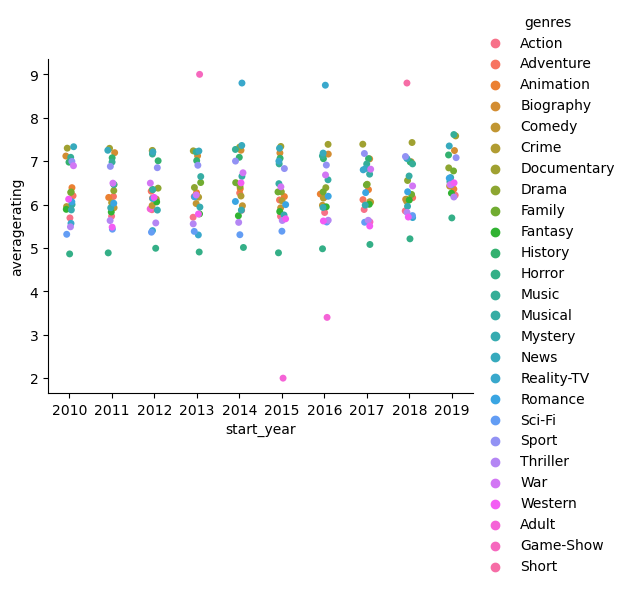

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data

df = pd.read_sql_query('''
SELECT start_year, genres, AVG(averagerating) as avg_rating
FROM movie_basics
JOIN movie_ratings
USING (movie_id)
GROUP BY start_year, genres
ORDER BY start_year, avg_rating DESC
''', con)
df.head()

# Need to create a second table associating each movie with its genre

df = pd.read_sql_query('''SELECT * FROM movie_basics JOIN movie_ratings USING (movie_id)''', con)
df.head()

df = df[['primary_title', 'start_year', 'genres', 'averagerating']]
df.head()

# Split genres column
df['genres'] = df['genres'].map(lambda x: x if x is None else x.split(','))
df = df.explode('genres')
final_genre_data = df.groupby(['start_year', 'genres']).mean()
genre2019 = df[df['start_year'] == 2019].groupby(['genres']).mean()
sns.catplot(data=final_genre_data, x="start_year", y="averagerating", hue="genres", kind="strip")

<Axes: title={'center': '2019 Average Movie Genre Ratings'}, ylabel='genres'>

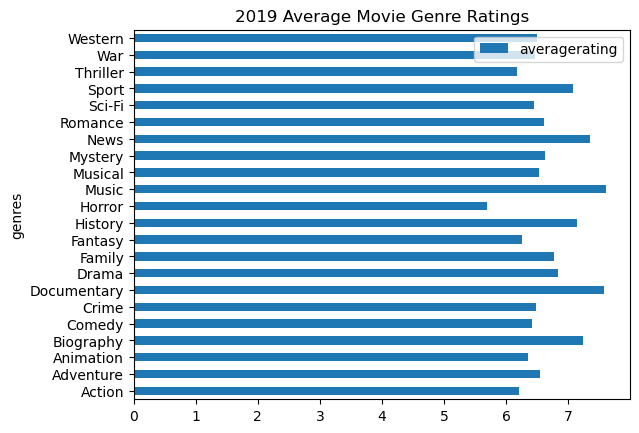

In [4]:
genre2019.plot(y='averagerating', kind='barh', title='2019 Average Movie Genre Ratings')

<Axes: title={'center': 'Overall Avg Movie Genre Ratings'}, ylabel='genres'>

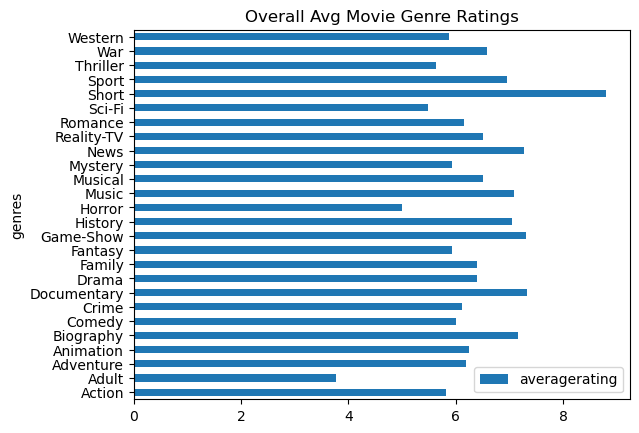

In [5]:
df = df[['genres','averagerating']].groupby(['genres']).mean()
df.plot(y='averagerating', kind='barh', title='Overall Avg Movie Genre Ratings')

C:\Users\grcosta\AppData\Local\Temp\ipykernel_5576\1471364191.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  genre2018rotten = rt[rt['year'] == '2018'].groupby(['genre']).mean()
C:\Users\grcosta\AppData\Local\Temp\ipykernel_5576\1471364191.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  final_rt_data_rotten = rt.groupby(['year', 'genre']).mean()


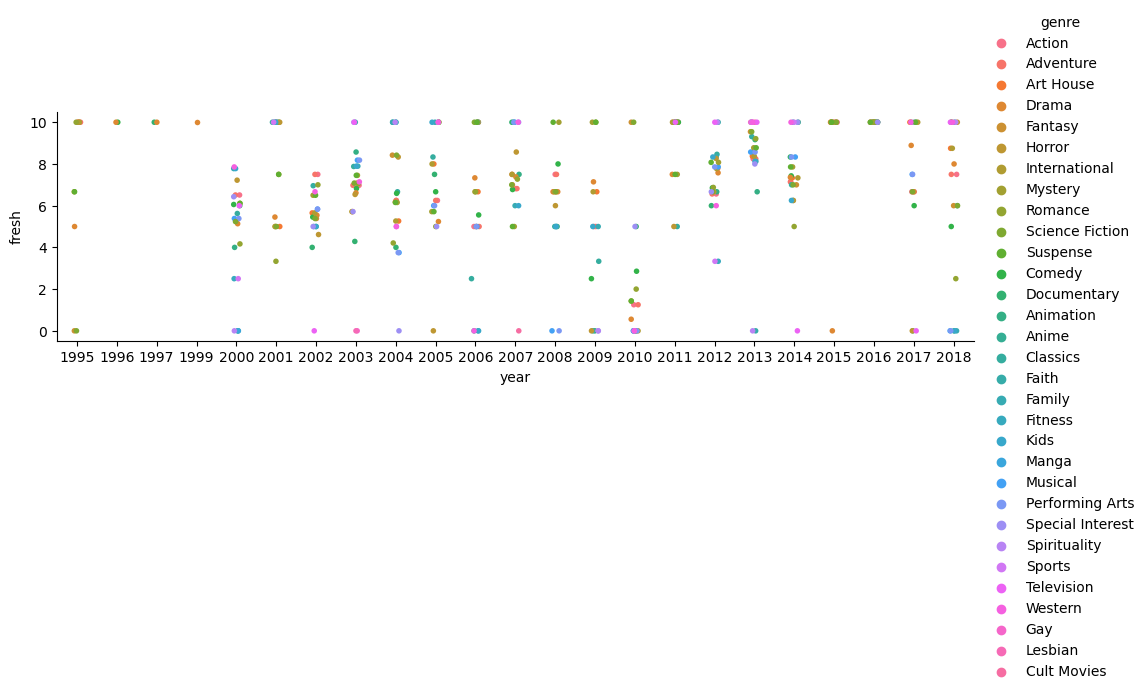

In [6]:
rtm = pd.read_csv('zippedData/rt.movie_info.tsv',sep='\t')
rtmr = pd.read_csv('zippedData/rt.reviews.tsv',sep='\t',encoding='ANSI')
rt = rtm.join(rtmr, on='id', rsuffix='_reviews')
rt['year'] = rt['date'].str[-4:]
rt['fresh'] = rt['fresh'].map(lambda x: 10 if x == 'fresh' else 0)
rt['genre'] = rt['genre'].map(lambda x: x if type(x) is not str else x.replace(' and ','|').split('|'))
rt = rt[['year', 'genre', 'rating_reviews', 'fresh']]
#TODO clean rating_reviews
rt = rt.explode('genre')
#2018 genres
genre2018rotten = rt[rt['year'] == '2018'].groupby(['genre']).mean()
#All years
final_rt_data_rotten = rt.groupby(['year', 'genre']).mean()
sns.catplot(data=final_rt_data_rotten, x="year", y="fresh", hue="genre", kind="strip", size=4, aspect=2)

<Axes: title={'center': '2018 Average Movie Genre Freshness'}, ylabel='genre'>

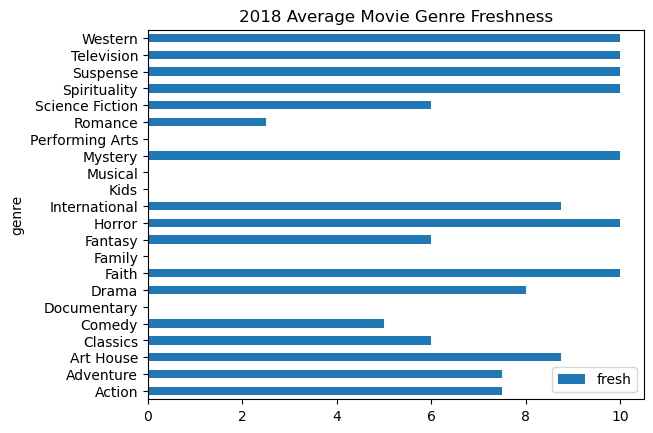

In [7]:
genre2018rotten.plot(y='fresh', kind='barh', title='2018 Average Movie Genre Freshness')

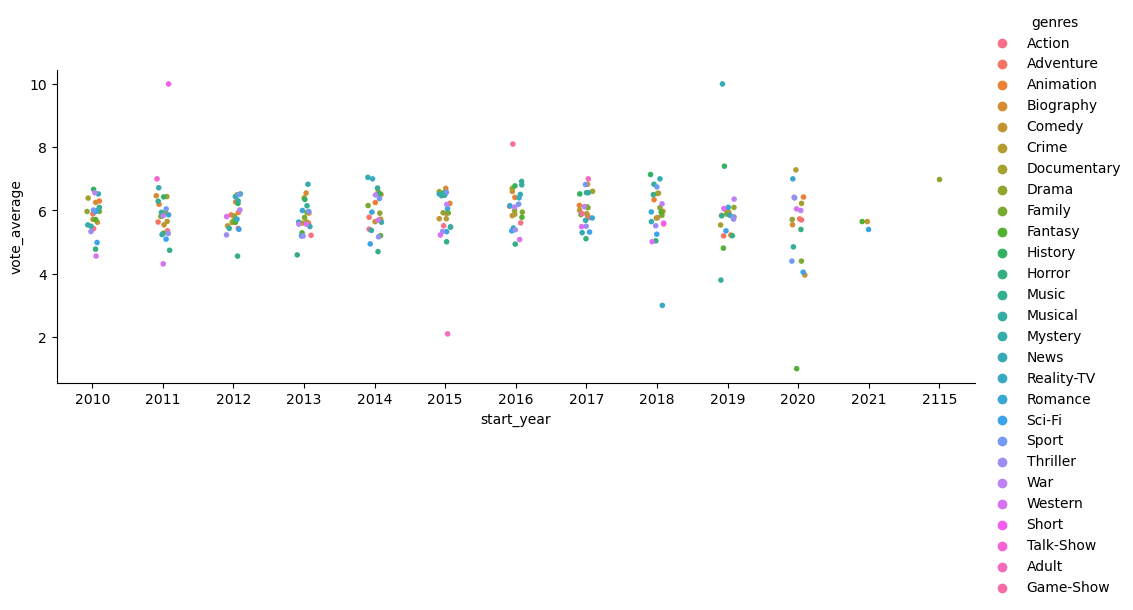

In [15]:
tmdb = pd.read_csv('zippedData/tmdb.movies.csv')
tmdb_combined = tmdb.set_index('title').join(df.set_index('primary_title'), rsuffix='_reviews', how='inner')
tmdb_combined['genres'] = tmdb_combined['genres'].map(lambda x: x if x is None else x.split(','))
tmdb_combined = tmdb_combined.explode('genres')[['start_year', 'genres', 'vote_average']]
tmdb_combined_years = tmdb_combined.groupby(['start_year', 'genres']).mean()
tmdb_combined_mean = tmdb_combined.groupby(['genres']).mean()
sns.catplot(data=tmdb_combined_years, x="start_year", y="vote_average", hue="genres", kind="strip", aspect=2, size=4)

<Axes: title={'center': 'TMDB Average Ratings by Genre'}, ylabel='genres'>

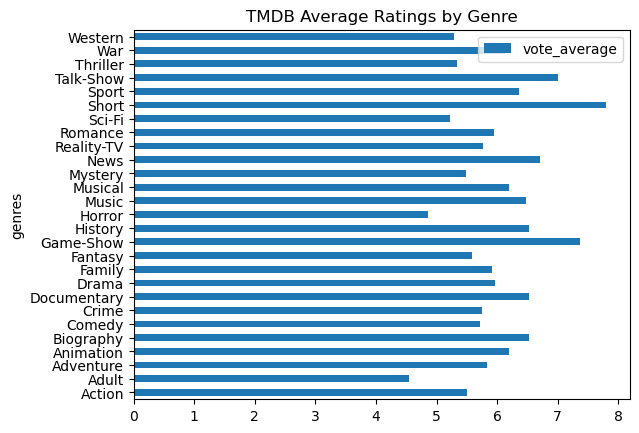

In [11]:
tmdb_combined_mean.plot(y='vote_average', kind='barh', title='TMDB Average Ratings by Genre')

<Axes: title={'center': 'TMDB Average Ratings by Genre'}, ylabel='genres'>

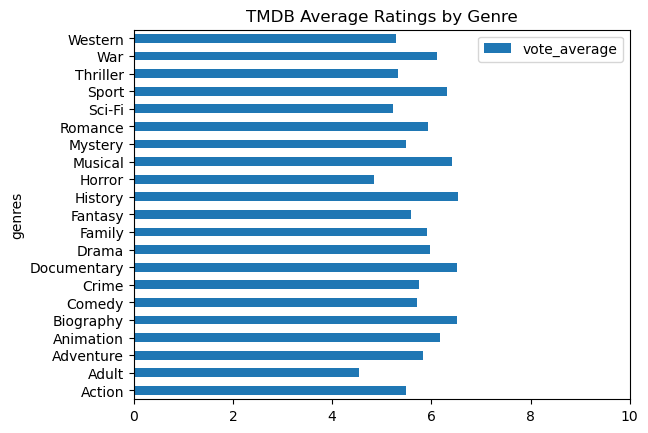

In [34]:
tmdb_combined_dr = tmdb_combined.drop(tmdb_combined[(tmdb_combined['genres'] == 'Talk-Show')
                                                     | (tmdb_combined['genres'] == 'Reality-TV')
                                                     | (tmdb_combined['genres'] == 'Game-Show')
                                                     | (tmdb_combined['genres'] == 'News')
                                                     | (tmdb_combined['genres'] == 'Short')].index)
tmdb_combined_dr['genres'] = tmdb_combined_dr['genres'].map(lambda x: x if x != 'Music' else 'Musical')
tmdb_combined_dr_mean = tmdb_combined_dr.groupby(['genres']).mean()
tmdb_combined_dr2019 = tmdb_combined_dr[tmdb_combined_dr['start_year'] == 2018].groupby(['genres']).mean()
tmdb_combined_dr_mean.plot(y='vote_average', kind='barh', title='TMDB Average Ratings by Genre', xlim=(0,10))

<Axes: title={'center': 'TMDB Average Ratings by Genre'}, ylabel='genres'>

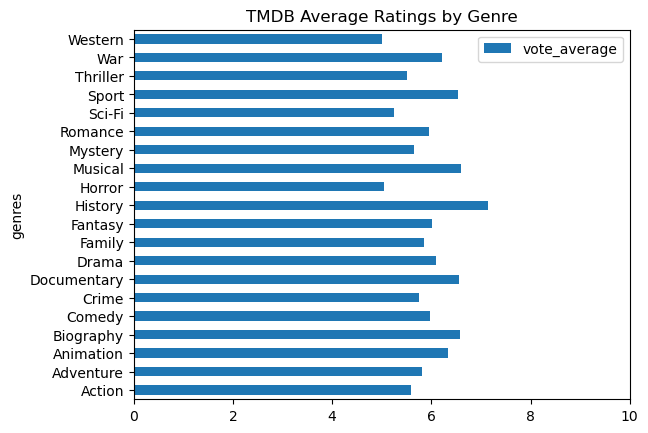

In [35]:
tmdb_combined_dr2019.plot(y='vote_average', kind='barh', title='TMDB Average Ratings by Genre', xlim=(0,10))